### Non-linear MPC for full Cart-pole

In [3]:
import sympy as smp

t, g, l, M, m, l = smp.symbols("t, g, l, M, m, l")
x, theta = smp.symbols(r"x, \theta", cls = smp.Function)

x = x(t)
xd = smp.diff(x, t)
xdd = smp.diff(xd, t)

theta = theta(t)
thetad = smp.diff(theta, t)
thetadd = smp.diff(thetad, t)

xm = x - l * smp.sin(theta)
ym = l * smp.cos(theta)

T = M / 2 * xd**2 + m / 2 * (smp.diff(xm, t)**2 + smp.diff(ym, t)**2)
V = m * g * ym

L = T - V

EL1 = (smp.diff(L, x) - smp.diff(L, xd, t)).simplify()

EL2 = (smp.diff(L, theta) - smp.diff(L, thetad, t)).simplify()

deriv2 = smp.solve([EL1, EL2], [xdd, thetadd])

xdd_rhs = deriv2[xdd].simplify()

thetadd_rhs = deriv2[thetadd].simplify()

xd_rhs_f = smp.lambdify((xd), xd)
xdd_rhs_f = smp.lambdify((x, theta, xd, thetad, m, M, g, l), xdd_rhs)

thetad_rhs_f = smp.lambdify((thetad), thetad)
thetadd_rhs_f = smp.lambdify((x, theta, xd, thetad, m, M, g, l), thetadd_rhs)

#(x, theta, xd, thetad)^T

def xdot(x, m, M, g, l):
    return [
        xd_rhs_f(x[2]),
        thetad_rhs_f(x[3]),
        xdd_rhs_f(x[0], x[1], x[2], x[3], m, M, g, l),
        thetadd_rhs_f(x[0], x[1], x[2], x[3], m, M, g, l)
    ]

#### Let us simulate the model first

In [4]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
import cv2

class Cart_pole:
    def __init__(self, x0, m, M, g, l, dt):
        self.x = x0
        self.m = m
        self.M = M
        self.g = g
        self.l = l
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.rhs = cs.vertcat(xd_rhs_f(self.symbolicx[2]),
                              thetad_rhs_f(self.symbolicx[3]),
                              xdd_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3], self.m, self.M, self.g, self.l),
                              thetadd_rhs_f(self.symbolicx[0],
                                            self.symbolicx[1],
                                            self.symbolicx[2],
                                            self.symbolicx[3], self.m, self.M, self.g, self.l))
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['ode'] = self.rhs
        
        self.dt = dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.dt})

    def simulation_step(self):
        res = self.F(x0 = self.x)

        self.x = res["xf"]
    
    def draw(self, cx, cy, scale = 100, color = (234, 123, 123), canvas = None,
                   alpha_0 = 0, WIND_X = 700):
        if (canvas is None):
            canvas = np.ones((700, 700, 3)) * 0

        x = int(self.x[0] * scale) % WIND_X - cx
        alpha = self.x[1]
        
        h, w, _ = canvas.shape

        cv2.line(canvas, (0, h // 2), (w, h // 2), color, 2)
        cv2.circle(canvas, (w // 2, h // 2), 7, color, 2)
        
        cv2.rectangle(canvas, (int(cx - w // 20 + x), cy - h // 40),
                              (int(cx + w // 20 + x), cy + h // 40), (213, 22, 123), -1)
        cv2.line(canvas, (int(cx + x), cy),
                         (int(cx + x - w / 5 * np.sin(alpha + alpha_0)),
                              cy - int(w / 5 * np.cos(alpha + alpha_0))), color, 2)
        cv2.circle(canvas, (int(cx + x - w / 5 * np.sin(alpha + alpha_0)),
                              cy - int(w / 5 * np.cos(alpha + alpha_0))), 7, color, 7)

        return canvas

m = 1
M = 5
g = 10
dt = 0.01
l = 2
F_max = 50

x0 = [1, 2, -0.2, 4]

cart_pole = Cart_pole(x0, m, M, g, l, dt)

WIND_X, WIND_Y = 700, 700

canvas = np.ones((WIND_Y, WIND_X, 3), np.uint8) * 60

while(True):
    canvas[:, :, :] = 60
    
    cart_pole.simulation_step()
    
    cv2.imshow("aascqsca", cart_pole.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas))
    
    key = cv2.waitKey(20)
    
    if (key == ord('q')):
        break

cv2.destroyAllWindows()
cv2.waitKey(10)

-1

#### Adding control

In [5]:
import sympy as smp

t, g, l, M, m, l, F = smp.symbols("t, g, l, M, m, l, F")
x, theta = smp.symbols(r"x, \theta", cls = smp.Function)

x = x(t)
xd = smp.diff(x, t)
xdd = smp.diff(xd, t)

theta = theta(t)
thetad = smp.diff(theta, t)
thetadd = smp.diff(thetad, t)

xm = x - l * smp.sin(theta)
ym = l * smp.cos(theta)

T = M / 2 * xd**2 + m / 2 * (smp.diff(xm, t)**2 + smp.diff(ym, t)**2)
V = m * g * ym

L = T - V

EL1 = (smp.diff(L, xd, t) - (smp.diff(L, x))).simplify() - F

EL2 = (smp.diff(L, thetad, t) - smp.diff(L, theta)).simplify()

deriv2 = smp.solve([EL1, EL2], [xdd, thetadd])
xdd_rhs = deriv2[xdd].simplify()
thetadd_rhs = deriv2[thetadd].simplify()

xd_rhs_f = smp.lambdify((xd), xd)
xdd_rhs_f = smp.lambdify((x, theta, xd, thetad, m, M, g, l, F), xdd_rhs)

thetad_rhs_f = smp.lambdify((thetad), thetad)
thetadd_rhs_f = smp.lambdify((x, theta, xd, thetad, m, M, g, l, F), thetadd_rhs)

In [6]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
import cv2

class Cart_pole:
    def __init__(self, x0, m, M, g, l, dt):
        self.x = x0
        self.m = m
        self.M = M
        self.g = g
        self.l = l
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.symbolicu = cs.MX.sym('p', 1)
        
        self.rhs = cs.vertcat(xd_rhs_f(self.symbolicx[2]),
                              thetad_rhs_f(self.symbolicx[3]),
                              
                              xdd_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.M, self.g, self.l,
                                        self.symbolicu),
                              
                              thetadd_rhs_f(self.symbolicx[0],
                                            self.symbolicx[1],
                                            self.symbolicx[2],
                                            self.symbolicx[3],
                                            self.m, self.M, self.g, self.l,
                                            self.symbolicu))
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.dt = dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.dt})

    def simulation_step(self, F):
        res = self.F(x0 = self.x, p = F)

        self.x = res["xf"]
    
    def get_state(self):
        return self.x
    
    def draw(self, cx, cy, scale = 100, color = (234, 123, 123), canvas = None,
                   alpha_0 = 0, WIND_X = 700):
        if (canvas is None):
            canvas = np.ones((700, 700, 3)) * 0

        x = int(self.x[0] * scale + cx) % WIND_X
        alpha = self.x[1]
        
        h, w, _ = canvas.shape

        cv2.line(canvas, (0, h // 2), (w, h // 2), color, 2)
        cv2.circle(canvas, (w // 2, h // 2), 7, color, 2)
        
        cv2.rectangle(canvas, (int(- w // 20 + x), cy - h // 40),
                              (int(+ w // 20 + x), cy + h // 40), (213, 22, 123), -1)
        cv2.line(canvas, (int(x), cy),
                         (int(x - w / 5 * np.sin(alpha + alpha_0)),
                              cy - int(w / 5 * np.cos(alpha + alpha_0))), color, 2)
        cv2.circle(canvas, (int(x - w / 5 * np.sin(alpha + alpha_0)),
                              cy - int(w / 5 * np.cos(alpha + alpha_0))), 7, color, 7)

        return canvas

#### Keyboard control

In [7]:
m = 1
M = 5
g = 10
dt = 0.01
l = 2
F_max = 50

x0 = [1, 2, -0.2, 4]

cart_pole = Cart_pole(x0, m, M, g, l, dt)

WIND_X, WIND_Y = 700, 700

canvas = np.ones((WIND_Y, WIND_X, 3), np.uint8) * 60

while(True):
    canvas[:, :, :] = 60
    
    key = cv2.waitKey(20)
    
    F = 0
    
    if (key == ord('b')):
        F = -F_max

    if (key == ord('m')):
        F = F_max

    cart_pole.simulation_step(F)
    
    cv2.imshow("aascqsca", cart_pole.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas))
        
    if (key == ord('q')):
        break

cv2.destroyAllWindows()
cv2.waitKey(10)

-1

#### NMPC

In [8]:
class NMPC_cartpole_controller:
    def __init__(self, m, M, g, l, control_step_dt, N, F_max):
        self.m = m
        self.M = M
        self.g = g
        self.l = l
        self.N = N
        self.F_max = F_max
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.symbolicu = cs.MX.sym('p', 1)
        
        self.rhs = cs.vertcat(xd_rhs_f(self.symbolicx[2]),
                              thetad_rhs_f(self.symbolicx[3]),
                              
                              xdd_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.M, self.g, self.l,
                                        self.symbolicu),
                              
                              thetadd_rhs_f(self.symbolicx[0],
                                            self.symbolicx[1],
                                            self.symbolicx[2],
                                            self.symbolicx[3],
                                            self.m, self.M, self.g, self.l,
                                            self.symbolicu))
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.control_step_dt = control_step_dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.control_step_dt})

    def generate_control(self, x0, x_target):
        self.symbolicx = x0

        u = cs.MX.sym('u', self.N, 1)

        for k in range(self.N):
            # Integrate 1s forward in time:
            # call integrator symbolically
            
            #print(u[k], self.symbolicx)
            
            res = self.F(x0 = self.symbolicx, p = u[k])
            self.symbolicx = res["xf"]

        # NLP declaration
        
        #print(self.symbolicx - x_target)
        
        nlp = {'x' : u, 'f' : cs.dot(self.symbolicx[0] - x_target[0],
                                     self.symbolicx[0] - x_target[0]) - 
                          2 * cs.cos(self.symbolicx[1] - x_target[1]) + 
                        0.2 * cs.dot(self.symbolicx[2:] - x_target[2:],
                                     self.symbolicx[2:] - x_target[2:])}

        opts = {'ipopt.print_level' : 0, 'print_time' : 0,
                'ipopt.max_iter' : 3}

        # Solve using IPOPT
        solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

        res = solver(x0 = 0.0, lbg = 0, ubg = 0, lbx = -self.F_max, ubx = self.F_max)

        return res['x'][0]

m = 1
M = 5
g = 10
dt = 0.1
l = 2
F_max = 50

x0 = [1, 3.14, 0, 0]

cart_pole = Cart_pole(x0, m, M, g, l, dt)

WIND_X, WIND_Y = 700, 700

canvas = np.ones((WIND_Y, WIND_X, 3), np.uint8) * 60

#attempt different world and control sampling time
freq_div = 5

N = 3
controller = NMPC_cartpole_controller(m, M, g, l, dt * freq_div, N, F_max)

F = 0

i = 0

while(True):
    canvas[:, :, :] = 60
    
    key = cv2.waitKey(50)
    
    state = cart_pole.get_state()
    
    print("state ", state[0])
    
    if (i % freq_div == 0):
        F = controller.generate_control(state, np.array([0, 0, 0, 0]))
        #print(F)

    cart_pole.simulation_step(F)
    
    cv2.imshow("aascqsca", cart_pole.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas))
        
    if (key == ord('q')):
        break
    
    i += 1

cv2.destroyAllWindows()
cv2.waitKey(10)

state  1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

state  0.993735
state  0.975002
state  0.943987
state  0.90099
state  0.846407
state  0.757097
state  0.610317
state  0.407623
state  0.15119
state  -0.156428
state  -0.46069
state  -0.709402
state  -0.903073
state  -1.04136
state  -1.12339
state  -1.16404
state  -1.18079
state  -1.17854
state  -1.16326
state  -1.14008
state  -1.10187
state  -1.03991
state  -0.954116
state  -0.843445
state  -0.706667
state  -0.544667
state  -0.359091
state  -0.150716
state  0.0791542
state  0.329299
state  0.552557
state  0.700509
state  0.775239
state  0.787946
state  0.756206
state  0.718078
state  0.698837
stat

-1

### Double pendulum swing-up

In [9]:
import sympy as smp

t, m, g, l, tau = smp.symbols(r't, m, l, g, \tau')

#alpha
a = smp.symbols(r'\alpha', cls = smp.Function)
a = a(t)
ad = smp.diff(a, t)
add = smp.diff(ad, t)

#beta
b = smp.symbols(r'\beta', cls = smp.Function)
b = b(t)
bd = smp.diff(b, t)
bdd = smp.diff(bd, t)

x1 = l * smp.sin(a)
y1 = l * smp.cos(a)

x2 = x1 + l * smp.sin(a + b)
y2 = y1 + l * smp.cos(a + b)

T = 1 / 2 * (m * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2) + 
             m * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2))

V = g * (m * y1 + m * y2)

L = (T - V).simplify()

EL1 = smp.diff(L, a) - smp.diff(L, ad, t) - tau
EL2 = smp.diff(L, b) - smp.diff(L, bd, t)

deriv2 = smp.solve([EL1.simplify(), EL2.simplify()], [add, bdd])

add_rhs = deriv2[add].simplify()
bdd_rhs = deriv2[bdd].simplify()

In [10]:
add_rhs_f = smp.lambdify((a, b, ad, bd, m, g, l, tau), add_rhs)
bdd_rhs_f = smp.lambdify((a, b, ad, bd, m, g, l, tau), bdd_rhs)

ad_rhs_f = smp.lambdify((ad), ad)
bd_rhs_f = smp.lambdify((bd), bd)

def xdot(x, m, g, l, tau):
    return [
        ad_rhs_f(x[2]),
        bd_rhs_f(x[3]),
        add_rhs_f(x[0], x[1], x[2], x[3], m, g, l, tau),
        bdd_rhs_f(x[0], x[1], x[2], x[3], m, g, l, tau)
    ]

xdot([1, 2, 3, 4], 1, 2, 3, 4)

[3, 4, 22.917741846386143, -21.470192912266373]

In [11]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
import cv2

class Double_pendulum:
    def __init__(self, x0, m, g, l, dt):
        self.x = x0
        
        self.m = m
        self.g = g
        self.l = l
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.symbolicu = cs.MX.sym('p', 1)
        
        self.rhs = cs.vertcat(ad_rhs_f(self.symbolicx[2]),
                              bd_rhs_f(self.symbolicx[3]),
                              
                              add_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.g, self.l,
                                        self.symbolicu),
                              
                              bdd_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.g, self.l,
                                        self.symbolicu))
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.dt = dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.dt})

    def simulation_step(self, tau):
        res = self.F(x0 = self.x, p = tau)

        self.x = res["xf"]
    
    def get_state(self):
        return self.x
    
    def polar_to_cartesian(self, l, a, b):
        x1 =   l * np.sin(a)
        y1 = - l * np.cos(a)

        x2 = x1 + l * np.sin(a + b)
        y2 = y1 - l * np.cos(a + b)

        return [[0.0, 0.0], [x1, y1], [x2, y2]]
    
    def draw(self, cx, cy, scale = 80, color = (234, 123, 123), canvas = None,
                   alpha_0 = 0, WIND_X = 700):
        if (canvas is None):
            canvas = np.ones((700, 700, 3)) * 0
        
        p0, p1, p2 = self.polar_to_cartesian(l, self.x[0], self.x[1])
        
        s = scale
        
        cv2.line(canvas, (int(p0[0] * s + WIND_X // 2), int(p0[1] * s + WIND_Y // 2)),
                         (int(p1[0] * s + WIND_X // 2), int(p1[1] * s + WIND_Y // 2)),
                         (123, 234, 23), 2)

        cv2.line(canvas, (int(p2[0] * s + WIND_X // 2), int(p2[1] * s + WIND_Y // 2)),
                         (int(p1[0] * s + WIND_X // 2), int(p1[1] * s + WIND_Y // 2)),
                         (123, 234, 23), 2)

        return canvas

In [14]:
class NMPC_double_pendulum_controller:
    def __init__(self, m, g, l, control_step_dt, N, tau_max):
        self.m = m
        self.g = g
        self.l = l
        self.tau_max = tau_max
        self.N = N
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.symbolicu = cs.MX.sym('p', 1)
        
        self.last_control = 0
        
        self.rhs = cs.vertcat(ad_rhs_f(self.symbolicx[2]),
                              bd_rhs_f(self.symbolicx[3]),
                              
                              add_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.g, self.l,
                                        self.symbolicu),
                              
                              bdd_rhs_f(self.symbolicx[0],
                                        self.symbolicx[1],
                                        self.symbolicx[2],
                                        self.symbolicx[3],
                                        self.m, self.g, self.l,
                                        self.symbolicu))
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.control_step_dt = control_step_dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.control_step_dt, 'expand' : True})

    def polar_to_cartesian(self, a, b):
        x1 =   self.l * cs.sin(a)
        y1 = - self.l * cs.cos(a)

        x2 = x1 + self.l * cs.sin(a + b)
        y2 = y1 - self.l * cs.cos(a + b)

        return (x2, y2)
    
    def generate_control(self, x0, x_target):
        self.symbolicx = x0

        u = cs.MX.sym('u', self.N, 1)

        for k in range(self.N):            
            res = self.F(x0 = self.symbolicx, p = u[k])
            self.symbolicx = res["xf"]

        # NLP declaration
        
        #print(self.symbolicx - x_target)
        
#         nlp = {'x' : u, 'f' : cs.dot(self.symbolicx[0] - x_target[0],
#                                      self.symbolicx[0] - x_target[0]) -
#                               5*cs.cos(self.symbolicx[1] - x_target[1]) +
#                               0.5*cs.dot(self.symbolicx[2:] - x_target[2:],
#                                      self.symbolicx[2:] - x_target[2:])
#                                                   }# +
                              #0.001*cs.dot(u, u)}

#         nlp = {'x' : u, 'f' :  -cs.cos(self.symbolicx[0] - x_target[0]) +
#                           - 1 * cs.cos(self.symbolicx[1] - x_target[1])  +
#                           0.15 * cs.dot(self.symbolicx[2:] - x_target[2:],
#                                        self.symbolicx[2:] - x_target[2:])}

        (x2, y2) = self.polar_to_cartesian(self.symbolicx[0], self.symbolicx[1])
    
        nlp = {'x' : u, 'f' : y2 + 1*cs.dot(x2, x2)}

        opts = {'ipopt.print_level' : 3, 'print_time' : 0,
                'ipopt.max_iter' : 3}#,
                #'ipopt.max_wall_time' : 0.1}#,
                #'ipopt.mu_strategy' : 'adaptive'}

        # Solve using IPOPT
        solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

        res = solver(x0 = self.last_control, lbg = 0, ubg = 0, lbx = -self.tau_max, ubx = self.tau_max)
        
        self.last_control = cs.vertcat(res['x'][1:], 0)

        return res['x'][0]

m = 1
g = 10
dt = 0.02
l = 2
tau_max = 30

x0 = [1, 2, -0.02, 0.04]
#x0 = [3, 2, -0.2, 0.4]

double_pendulum = Double_pendulum(x0, m, g, l, dt)

WIND_X, WIND_Y = 700, 700

canvas = np.ones((WIND_Y, WIND_X, 3), np.uint8) * 60

#attempt different world and control sampling time
freq_div = 20

N = 3
controller = NMPC_double_pendulum_controller(m, g, l, dt * freq_div, N, tau_max)

i = 0

while(True):
    canvas[:, :, :] = 60
    
    key = cv2.waitKey(5)
    
    state = double_pendulum.get_state()
    
    #print("state ", state[0])
    
    if (i % freq_div == 0):
        tau = controller.generate_control(state, np.array([0, 0, 0, 0]))
        print(tau)

    double_pendulum.simulation_step(tau)
    
    cv2.imshow("aascqsca", double_pendulum.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas))
        
    if (key == ord('q')):
        break
    
    if (i == 0):
        cv2.waitKey(0)
    
    i += 1

cv2.destroyAllWindows()
cv2.waitKey(10)

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   2.5366912306229197e+00    2.5366912306229197e+00
Dual infeasibility......:   4.9173636526364450e-03    4.9173636526364450e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   3.2059800130383622e+00    3.2059800130383622e+00
Dual infeasibility......:   2.2426287036282997e-03    2.2426287036282997e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:  -1.8156249204594448e+00   -1.8156249204594448e+00
Dual infeasibility......:   4.8357936559284281e-01    4.8357936559284281e-01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:  -3.9975345629073082e+00   -3.9975345629073082e+00
Dual infeasibility......:   3.5522150850346252e-03    3.5522150850346252e-03
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:  -3.9999999998619002e+00   -3.9999999998619002e+00
Dual infeasibility......:   1.8117980841276940e-06    1.8117980841276940e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

-1

### Van der Pol oscillator

In [21]:
import numpy as np
import sympy as smp

t, m, F, mu = smp.symbols('t, m, F, \mu')

x = smp.symbols('x', cls = smp.Function)

x = x(t)
xd = smp.diff(x, t)
#xdd = smp.diff(xd, t)

xdd_rhs = (mu * (1 - x**2) * xd  - x + F) / m

#L = m * x_d**2 / 2

#EL1 = - smp.diff(L, x) + smp.diff(L, x_d, t) - F

#EL1

In [22]:
xdd_rhs

(F + \mu*(1 - x(t)**2)*Derivative(x(t), t) - x(t))/m

In [23]:
xdd_rhs_f = smp.lambdify((x, xd, m, mu, F), xdd_rhs)

xdd_rhs_f(2, 3, 5, 5, 6)

-8.2

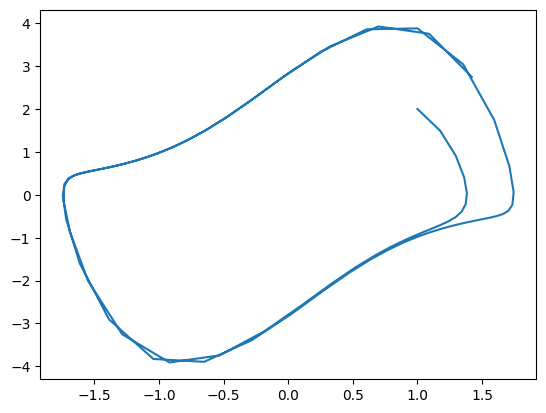

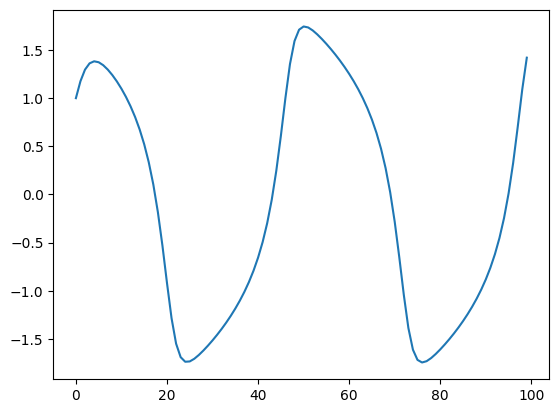

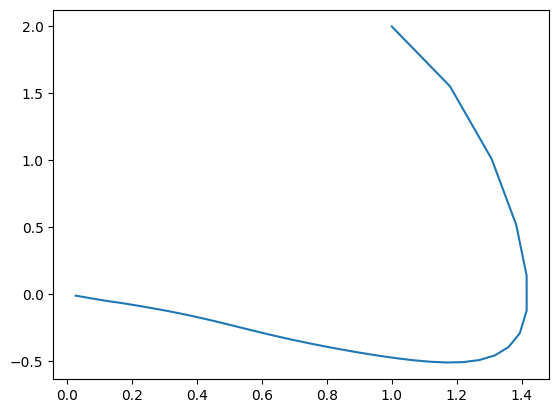

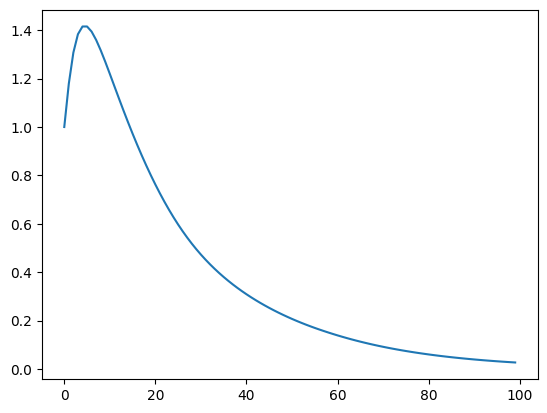

In [32]:
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np

class Van_der_Pol_oscillator:
    def __init__(self, m, mu, x0, dt):
        self.m  = m
        self.mu = mu
        self.x  = x0
        self.dt = dt
        
        self.symbolicx = cs.MX.sym('x', 2)
        self.symbolicu = cs.MX.sym('p')
                
        self.rhs = cs.vertcat(self.symbolicx[1],
                         xdd_rhs_f(self.symbolicx[0],
                                   self.symbolicx[1],
                                   self.m,
                                   self.mu,
                                   self.symbolicu))

        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.dt, 'expand' : True})
        
    def simulation_step(self, F):
        self.x = self.F(x0 = self.x, p = F)["xf"]
    
    def get_state(self):
        return self.x

def nmpc_controller(x0, x_target, control_dt, m, mu, N, F_max):
    symbolicx = cs.MX.sym('x', 2)
    symbolicu = cs.MX.sym('p')
    
    rhs = cs.vertcat(symbolicx[1],
                     xdd_rhs_f(symbolicx[0],
                               symbolicx[1],
                               m,
                               mu,
                               symbolicu))
    
    ode = {}         # ODE declaration
    ode['x']   = symbolicx   # states
    ode['p']   = symbolicu
    ode['ode'] = rhs # right-hand side

    # Construct a Function that integrates over 1s
    F = cs.integrator('F', 'cvodes', ode, {'tf' : control_dt, 'expand' : True})

    x = x0
    
    u = cs.MX.sym('u', N, 1)
    
    for k in range(N):
        res = F(x0 = x, p = u[k])
        x = res["xf"]

    nlp = {'x' : u, 'f' : cs.dot(x[0] - x_target, x[0] - x_target) +
                          cs.dot(x[1], x[1]) +
                    0.01 * cs.dot(u, u)}
    
    opts = {'ipopt.print_level' : 0, 'print_time' : 0,
            'ipopt.max_iter' : 3}

    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)
        
    res = solver(x0 = 0.0, lbg = 0, ubg = 0, lbx = - F_max, ubx = F_max)
        
    return res['x'][0]

x0 = [0, -1]
step_num = 30
control_dt = 1
m = 3
mu = 3

def PD_controller(x, x_target, control_dt, m, mu, N, F_max):
    Kp, Kd = 1, 1
    
    F = - Kp * (x[0] - x_target) - Kd * x[1]
    
    F = np.clip(F, -F_max, F_max)
    
    return F

def simulate_oscillator(x0, m, mu, dt, F_max, iter_num, controller):
    oscillator = Van_der_Pol_oscillator(m, mu, x0, dt)

    freq_div = 1

    N = 3

    i = 0

    x_hist = []
    xd_hist = []

    while(i < iter_num):
        state = oscillator.get_state()
        x_hist.append(state[0])
        xd_hist.append(state[1])

        if (i % freq_div == 0):
            tau = controller(state, 0, dt * freq_div, m, mu, N, F_max)

        oscillator.simulation_step(tau)

        i += 1

    plt.plot(x_hist, xd_hist)
    plt.show()
    
    plt.plot(x_hist)
    plt.show()
    
    return x_hist, xd_hist

_, _ = simulate_oscillator([1, 2], 1, 3, 0.1, 3, 100, PD_controller)

_, _ = simulate_oscillator([1, 2], 1, 3, 0.1, 3, 100, nmpc_controller)

### Satellite in the gravitational field

In [37]:
import numpy as np
import casadi as cs
import cv2
import matplotlib.pyplot as plt

class Satellite:
    def __init__(self, x0, m, G0, dt):
        self.x = x0
        
        self.m = m
        self.G0 = G0
        
        self.symbolicx = cs.MX.sym('x', 4)
        self.symbolicu = cs.MX.sym('p', 1)
        
        dist3 = cs.sqrt(self.symbolicx[0]**2 + self.symbolicx[1]**2)**3
        
        self.rhs = cs.vertcat(self.symbolicx[2],
                              self.symbolicx[3],
                            - self.symbolicx[0] * self.G0 / dist3,
                            - self.symbolicx[1] * self.G0 / dist3)
        
        self.ode = {}
        self.ode['x'] = self.symbolicx
        self.ode['p'] = self.symbolicu
        self.ode['ode'] = self.rhs
        
        self.dt = dt

        self.F = cs.integrator('F', 'cvodes', self.ode, {'tf' : self.dt})

    def simulation_step(self, F):
        res = self.F(x0 = self.x, p = F)

        self.x = res["xf"]
    
    def get_state(self):
        return self.x
        
    def draw(self, cx, cy, scale = 80, color = (234, 123, 123), canvas = None,
                   alpha_0 = 0, WIND_X = 700):
        if (canvas is None):
            canvas = np.ones((700, 700, 3)) * 0

        x = int(self.x[0] * scale) + cx
        y = int(self.x[1] * scale) + cy
        
        h, w, _ = canvas.shape

        cv2.circle(canvas, (w // 2, h // 2), 27, color, 3)
        #cv2.circle(canvas, (w // 2, h // 2), 7, color, 2)
        cv2.circle(canvas, (x, y), 7, (123, 34, 234), -1)
        
        return canvas

m = 1
G0 = 10
dt = 0.03
#tau_max = 30

x0 = [1, 2, -2, 0]

satellite = Satellite(x0, m, G0, dt)

WIND_X, WIND_Y = 700, 700

canvas = np.ones((WIND_Y, WIND_X, 3), np.uint8) * 60

#attempt different world and control sampling time
freq_div = 20

#N = 3
#controller = NMPC_double_pendulum_controller(m, g, l, dt * freq_div, N, tau_max)

i = 0

F = 0

while(True):
    canvas[:, :, :] = 60
    
    key = cv2.waitKey(15)
    
    state = double_pendulum.get_state()
    
    #print("state ", state[0])
    
    #if (i % freq_div == 0):
    #    tau = controller.generate_control(state, np.array([0, 0, 0, 0]))
    #    print(tau)

    satellite.simulation_step(F)
    
    cv2.imshow("aascqsca", satellite.draw(WIND_X // 2, WIND_Y // 2, canvas = canvas))
        
    if (key == ord('q')):
        break
    
    #if (i == 0):
    #    cv2.waitKey(0)
    
    i += 1

cv2.destroyAllWindows()
cv2.waitKey(10)

-1